In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf 
import math as m
# more libraries required
from sklearn.preprocessing import OneHotEncoder, normalize, MinMaxScaler

import recommender_v4_1 as v4_1

In [2]:

file_path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/Rot3 AA/Recommender phase 2/datasets/backtesting/carnpar_202404_sample"
df_x =  pd.read_csv(file_path)
df_x = df_x[[col for col in df_x.columns if col != 'pol_type_desc'] + ['pol_type_desc']]


#current data
file_path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/Rot3 AA/Recommender phase 2/datasets/backtesting/carnpar_current"
df_c =  pd.read_csv(file_path) #up-to-date data
df_c = df_c[[col for col in df_c.columns if col != 'pol_type_desc'] + ['pol_type_desc']]

In [3]:
pol_columns_x,cat_col_x, Dx,id_col = v4_1.prep(df_x.copy())
pol_columns_c,cat_col_c, Dc,id_col = v4_1.prep(df_c)

In [ ]:
def gradient_descent_weightings( cw, jw,pol_columns_r,cat_col_r,Rx,Dx,Dc,id_col,step):
    recs_df = v4_1.recommender(6, cw, jw,pol_columns_r,cat_col_r,Rx.copy())
    pids = recs_df[id_col].drop_duplicates() #pids that have recommendations, training pids

    df_new = v4_1.backtesting(Dx,Dc,pids,id_col,recs_df) #backtesting on the current fold

    mod_score = np.mean(df_new['MRR_4_score'])
    del df_new
    
    loss_step = v4_1.gradient(cw,jw,step,Rx, pol_columns_r, cat_col_r, id_col,Dx,Dc,pids) #loss for each weighting
    d_loss = loss_step - np.full_like(loss_step, 1- mod_score)#differnce in loss

    cw_next = cw - d_loss[0:len(cw)]
    jw_next = jw - d_loss[len(cw):]
    
    return cw_next, jw_next, np.linalg.norm(d_loss), mod_score



'''runs k folds of training sets (some sample of backdated data) through recommender, and backtests each'''
def k_folds_optimization_weights(df_x,k,Dx,Dc,steps):

    fold_sample_size = 1000

    t = len(steps) #number of iterations to take in the gradient descent
    #training data (subset of backdated data)
    pol_columns_r,cat_col_r, Rx,id_col = v4_1.prep(df_x.copy().drop(columns = ['businessentityname', 'trn_grp_desc', 'prod_house_desc',
           'prod_tbl_grp_desc', 'psm_opt_desc',  'sky_pol_type_desc', 'product_desc', 'prod_tbl_cd', 'pa_sts_desc','business_only_indicator', 
           'death_benefit_indicator','pps_full_flag'])) 
    #pol_columns_r,cat_col_r, Rx,id_col = prep(df_x.copy())
    #columns dropped because of previous model's target leakage, but model performs better without these columns...
    #Maybe investigate effect of keeping/dropping certain columns

    Rx = Rx.drop(columns = ['pol_count','no unique products','set of policies']).set_index(id_col)
    
    score_steps_ave = np.array([0]*t)
    fold_steps_ave = np.array([0]*t)
    for i in range(k):
        e = 0.1 #error value for gradient descent
        #step = 3 #update step for weightings

        Rx_s = Rx.copy().sample(fold_sample_size) #the fold of data used for optimization

        cw = (1)*np.array([1] *(Rx_s.shape[1] -cat_col_r)) 
        jw = (1)*np.array([1] *(cat_col_r)) #include policy info

        #--------------------optimizations of weightings------------------

        fold_scores = []
        fold_loss = []
        for step in steps: #as e tend to zero the change in the "loss" value tends to zero
            cw,jw,e,score = gradient_descent_weightings(cw,jw,pol_columns_r,cat_col_r,Rx_s,Dx,Dc,id_col,step) 
            fold_scores.append(score)
            fold_loss.append(e)
        score_steps_ave = np.add(score_steps_ave,fold_scores)
        fold_steps_ave = np.add(fold_steps_ave,fold_loss)


        #------------------------------------------------------------------------
    score_steps_ave = score_steps_ave/k
    fold_steps_ave = fold_steps_ave/k
    return score_steps_ave

'''returns the average score and average fold loss for all folds over each step'''



'returns the average score and average fold loss for all folds over each step'

In [5]:
def gradient_steps(steps,df_x,k,Dx,Dc):
    loss_step = []
    step_step_size = 0.3 #step size for the gradient descent on steps
    for i in range(0,len(steps)):
        steps_n = list(steps)
        steps_n[i] += step_step_size
        score_steps_ave = k_folds_optimization_weights(df_x,k,Dx,Dc,steps_n)
        loss_step.append(1-score_steps_ave[-1])#final loss after all iterations of weighting optimization
    return np.array(loss_step)



def gradient_descent_steps(df_x,k,Dx,Dc,steps):

    score_steps_ave = k_folds_optimization_weights(df_x,k,Dx,Dc,steps)
    print('current score',score_steps_ave)
    loss_step = gradient_steps(steps,df_x,k,Dx,Dc) #loss for each step difference
    print(loss_step)
    d_loss = loss_step - np.full_like(loss_step, 1- score_steps_ave)#differnce in loss
    print(d_loss)
    steps_next = steps - d_loss
    print('step_next',steps_next)

    return steps_next,np.linalg.norm(d_loss)

In [ ]:

k=2 #how many folds for training
step_size = 1.68 
steps = np.array([step_size]*10) #starting step vector (would have 10 iterations for weighting optimization)



In [ ]:
#--------------------optimizations of steps------------------
#Note: fold_sample_size is specified in the k_folds_optimization_weights function

i = 7 #iterate i times to optimize step vector
while i>0:
    steps, e = gradient_descent_steps(df_x,k,Dx,Dc,steps)
    print(f'iterarion {i} done',steps, e)
    i = i-1


current score [0.40073529 0.41911765 0.44117647 0.45955882 0.46691176 0.49264706
 0.49264706 0.51102941 0.51102941 0.51838235]
[0.52586207 0.44990695 0.4280303  0.39404762 0.34393668 0.37483422
 0.44196429 0.51607143 0.4625     0.41826923]
[-0.07340264 -0.13097541 -0.13079323 -0.14639356 -0.18915156 -0.13251872
 -0.06538866  0.02710084 -0.02647059 -0.06334842]
step_next [1.75340264 1.81097541 1.81079323 1.82639356 1.86915156 1.81251872
 1.74538866 1.65289916 1.70647059 1.74334842]
iterarion 7 done [1.75340264 1.81097541 1.81079323 1.82639356 1.86915156 1.81251872
 1.74538866 1.65289916 1.70647059 1.74334842] 0.3523404813135037
current score [0.65982759 0.67344828 0.67775862 0.68706897 0.68706897 0.69137931
 0.69137931 0.69137931 0.7        0.705     ]
[0.47348485 0.5375     0.46964286 0.36134615 0.55158046 0.3040625
 0.51302083 0.48303671 0.43134236 0.41135817]
[ 0.13331243  0.21094828  0.14740148  0.04841512  0.23864943 -0.00455819
  0.20440014  0.17441602  0.13134236  0.11635817]
ste

In [ ]:
recs = 6 #number of recommendations wanted
k = 3
#copy step vector from optimization output and copy the values a few times in order to get a longer optimization of weigthings using dynamic step sizes
#One could obviously run the step optimization for a larger step vector to achieve this but the run time will be massive

steps = [1.90523723,1.90523723,1.90523723,1.90523723, 1.93402311,1.93402311,1.93402311,1.93402311,1.93402311, 1.74665075, 1.74665075, 1.74665075, 1.74665075, 1.74665075, 1.95701029, 1.95701029,1.95701029,1.95701029,1.95701029,1.95209462, 1.95209462,1.95209462,1.95209462,1.95209462,2.03673667,2.03673667,2.03673667,2.03673667,
 1.40572346, 1.40572346, 1.40572346, 1.40572346, 1.65264574 , 1.65264574 , 1.65264574 , 1.65264574 ,1.71402718 ,1.71402718,1.71402718,1.71402718,1.78244729,1.78244729,1.78244729,1.78244729]
score_steps_ave = k_folds_optimization_weights(df_x,k,Dx,Dc,steps)


C:\Users\E1005279\AppData\Local\Temp\ipykernel_19752\4216751342.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


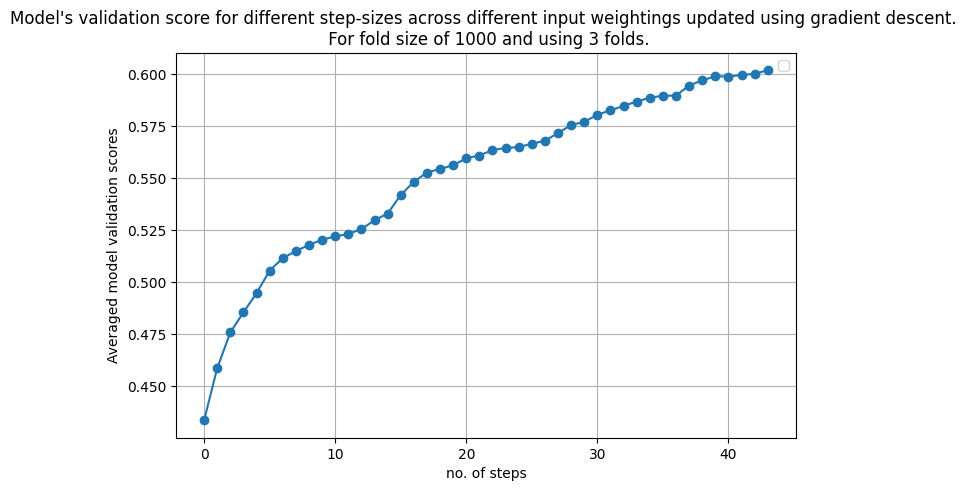

In [15]:
# Create a plot
plt.figure(figsize=(8, 5))

# Plot each key's values with a different color

plt.plot(score_steps_ave, marker='o')

# Add labels and legend
plt.xlabel("no. of steps")
plt.ylabel("Averaged model validation scores")
plt.title(f"Model's validation score for different step-sizes across different input weightings updated using gradient descent. \n For fold size of 1000 and using {k} folds.")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()